# Demo - Bayesian Neural Network Regression

In [1]:
import numpy as np
from sklearn import datasets
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Generate Sample Data

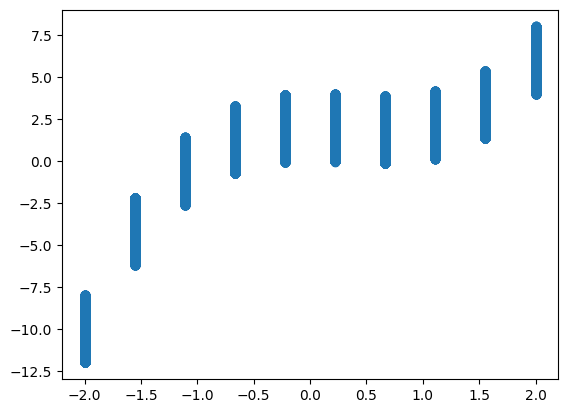

In [29]:
x = torch.linspace(-2, 2, 10)
x = torch.repeat_interleave(x, 10000)
y = x.pow(3) - x.pow(2) + 4*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

## 2. Define Model

In [30]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10, out_features=1),
)

In [31]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3. Train Model

In [32]:
kl_weight = 0.1

In [33]:
def calculate_weight_variance(layer):
    weight_var = layer.weight_log_sigma.exp()
    return weight_var.mean().item()

In [34]:
model_variance = []
for step in tqdm(range(1000)):
    
    x_epoch = x[step*10:(step+1)*10]
    y_epoch = y[step*10:(step+1)*10]
    for _ in range(10):
        pre = model(x_epoch)
        mse = mse_loss(pre, y_epoch)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    model_variance.append(calculate_weight_variance(model[0]))
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 378/1000 [00:12<00:19, 31.13it/s]


KeyboardInterrupt: 

In [35]:
### two neural network system 
model1 = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10, out_features=1),
)
model2 = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=10),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10, out_features=1),
)

model_variance1 = []
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
for step in tqdm(range(1000)):
    x_epoch = x[step*10:(step+1)*10]
    y_epoch = y[step*10:(step+1)*10]
    

    for _ in range(10):
        pre1 = model1(x_epoch)
        mse1 = mse_loss(pre1, y_epoch)
        kl1 = kl_loss(model1)
        cost1 = mse1 + kl_weight*kl1
        optimizer1.zero_grad()
        cost1.backward()
        optimizer1.step()

    ### Sample from model1 and use it as input for model2
    y_epoch_model2 = model1(x_epoch).detach() + torch.randn_like(x_epoch)*0.01
    for _ in range(10):
        pre2 = model2(x_epoch)
        mse2 = mse_loss(pre2, y_epoch_model2)
        kl2 = kl_loss(model2)
        cost2 = mse2 + kl_weight*kl2
        optimizer2.zero_grad()
        cost2.backward()
        optimizer2.step()

    ### copy weights from model2 to model1
    model1[0].weight_mu.data = model2[0].weight_mu.data.clone()
    model1[0].weight_log_sigma.data = model2[0].weight_log_sigma.data.clone()
    model1[0].bias_mu.data = model2[0].bias_mu.data.clone()
    model1[0].bias_log_sigma.data = model2[0].bias_log_sigma.data.clone()
    model1[2].weight_mu.data = model2[2].weight_mu.data.clone()
    model1[2].weight_log_sigma.data = model2[2].weight_log_sigma.data.clone()
    model1[2].bias_mu.data = model2[2].bias_mu.data.clone()
    model1[2].bias_log_sigma.data = model2[2].bias_log_sigma.data.clone()
 
    model_variance1.append(model1[2].weight_log_sigma.exp().mean().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:30<00:00, 11.05it/s]


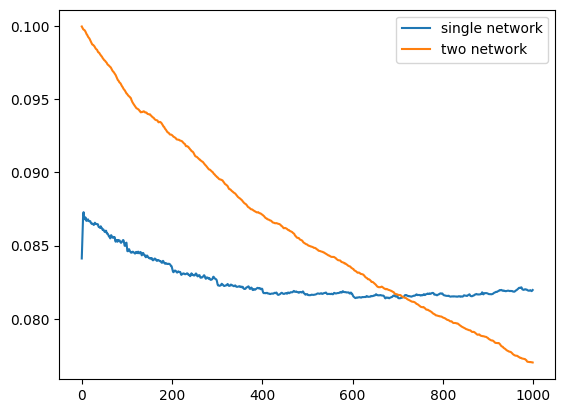

In [ ]:
plt.plot(model_variance,label='single network')
plt.plot(model_variance1,label='two network')
plt.legend()

## 4. Test Model

In [8]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

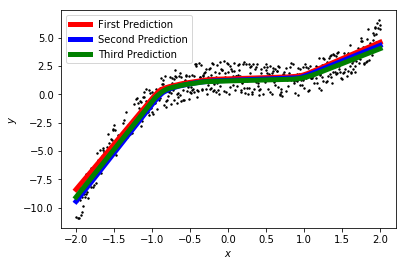

In [9]:
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2) 

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=5, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=5, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=5, label='Third Prediction')

plt.legend()

plt.show()